# Data Analysis and Muon Lifetime

In this notebook we will discuss histograms, statistics, curve fitting, and analyzing simulated data from the muon lifetime experiment.



**First things first, make sure you save this notebook to your drive so you can save your changes!!!**

<div>
<img src="save_to_drive.png" width="250"/>
</div>

In [2]:
# import libraries needed.  Run this block of code without modification.

%matplotlib notebook
%matplotlib inline

import numpy as np
import scipy.optimize as opt
import scipy.integrate as integrate
import scipy.stats as stats
import matplotlib.pyplot as plt
import inspect

### Exercise 1: Define a gaussian distribution

The equation for a gaussian distribution is:

$$ \Large f(x)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$$

Where $\mu$ is the mean and $\sigma$ is the width.  Define a python function called `gaussian` which accepts 3 arguments: `x`, `sigma` and `mean`.  The default value for `sigma` shoud be `1.0` and for mean `0.0`.  Default values are specified in the arugments to the function as `def func(arg1, arg2=1.0):`.

You will need `np.sqrt`, `np.exp`, `np.power`, `np.pi` for square roots, exponentials, raising a number to a power, and using $\pi$.  Note that `np.pi` is a *member*, not a *function*, so you do not need the parentheses `()` when using `np.pi`.

In [3]:
def gaussian(x, sigma=1.0, mean=0.0):
    return 1.0/np.sqrt(2*np.pi)/sigma*np.exp(-0.5*np.power((x-mean)/sigma,2))

Plot your gaussian function by defining an array of points using `np.linspace`.  Then use `plt.plot` to plot that array and the gaussian function.  Make sure that when you change `sigma` and `mean` you get the expected result.

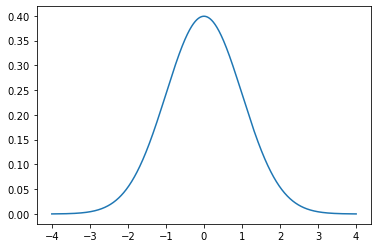

In [4]:
x = np.linspace(-4,4,1000)
plt.plot(x, gaussian(x))

### Exercise 2: Define a Laplace distribution

A gaussian is not the only distribution which has a mean and width.  In fact, you may find the functional form of a gaussian distribution strange.  Why is $x$ squared in the exponent, for example?  Why is $\pi$ there, and why is it the square root of $\pi$?  It seems like a strange choice for a distribution!  We can also define the Laplace, or "double exponential" distribution, where just the absolute value of $x$ is in the exponent, not $x^2$:

$$ \Large f(x)=\frac{1}{\sqrt{2}\sigma}e^{\left(\frac{-\sqrt{2}|x-\mu|}{\sigma}\right)}$$

Define the Laplace distribution below.  Use the function `np.abs` to compute the absolute value.  Again, the arguments are `x`, `sigma`, and `mean`, and `sigma` should default to `1.0` and mean should default to `0.0`.

In [5]:
def laplace(x, sigma=1.0, mean=0.0):
    return 1.0/np.sqrt(2)/sigma*np.exp(-np.sqrt(2)*np.abs(x-mean)/sigma)

Similarly to the gaussian distribution, plot the laplace distribution and verify that changing the `sigma` and `mean` make sense.  Try plotting them both together with the same value of `sigma` and `mean`.

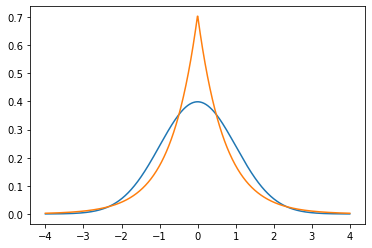

In [6]:
plt.plot(x, gaussian(x))
plt.plot(x, laplace(x))

The distributions have some similarities and some differences!  They appear to have very roughly the same "width" when we set the value of `sigma` to be the same for both distributions.  However, the Laplace distribution is pointy and has more probability "mass" concentrated near the center while the gaussian distribution is smooth and more spread out.  Later in this notebook we will explore fitting a set of observed data to both distributions and seeing which one fits the data better.

### Exercise 3: Normalization of Probability Density Functions

One property of a **Probability Density Function** or PDF is that its integral is exactly 1.  You can think of this as adding up all the individual probabilities of every possible outcome and getting 100%.  Verify that the integral of these distributions is 1 regardless of the choice of `mean` and `sigma`.  To perform this integral numerically, perform the following steps:


1. Create a linearly spaced set of points `x` using `np.linspace`
2. Call the function, either `gaussian(x)` or `laplace(x)` over the linearly spaced set of points.
3. Use the built-in function `sum` to add together all of the values.
4. Multiply by d$x$: the spacing between points.  You can find it by typing: `dx=x[1]-x[0]`.  The function value is the "height" of the rectangle and d$x$ is the "width".
5. Try several different values for `sigma` and `mean`.  Make sure that if you change them you also appropriately change the range.  The range should be at least from `mean-4*sigma` to `mean+4*sigma`.
6. Optional challenge: write a new function which numerically integrates a user provided function over the bounds `a` to `b` using the "algorithm" defined here.  Now, you can easily reuse your function to integrate several PDFs.  Completing this challenge will require you to use a special new syntax: passing the argument `**kwargs` to the new function you write to perform your numerical integration.  If python is a challenge for you then you can feel free to skip this exercise.


In [111]:
x = np.linspace(-100,100,100000)
print(sum(gaussian(x)*(x[1]-x[0])))
print(sum(laplace(x)*(x[1]-x[0])))
print(sum(gaussian(x,sigma=2)*(x[1]-x[0])))
print(sum(laplace(x,sigma=2,mean=-1)*(x[1]-x[0])))

def numerical_integration(f, **kwargs):
    x = np.linspace(-100,100,100000)
    return sum(gaussian(x, **kwargs)*(x[1]-x[0]))

print(numerical_integration(gaussian))
print(numerical_integration(laplace))
print(numerical_integration(gaussian, sigma=2))
print(numerical_integration(laplace, sigma=2, mean=-1))

0.9999999999979661
0.999999666658035
0.9999999999979657
0.9999999166879496
0.9999999999979661
0.9999999999979661
0.9999999999979657
0.9999999999979674


### Fitting Histograms

The code below defines a function `plot_data_and_fit` which accepts a list or numpy array of observed data and creates a histogram and fits it to a function of your choice.

Read the code and try to understand the algorithm even if you don't understand each individual line of code.  Then, run the block of code with no modification.

In [147]:
#
# DO NOT MODIFY THIS CODE BLOCK

# define a style dictionary for data-like plotting
data_style={'color':'k', 'marker':"o", 'linestyle':'None', 'label':'Observed Data'}

'''
The method to plot a histogram and fit it to an arbitrary function.

Arguments:
 - observed data: array-like object containing all of the individual observations
 - num_bins:      number of bins for the histogram.  Default=10
 - function:      callable object representing the function we will fit to the data.
                  Default= the gaussian function you defined earlier.
 - guess:         Initial guess of parameter values.  If no guess is provided then it is initialized to 1 for
                  each parameter
'''
def plot_data_and_fit(observed_data, num_bins=10, function=gaussian, guess=[], doPlot=True):
    # get information about the fitting function.  The independent variable name, fit parameters, function name
    x_axis_name   = inspect.getfullargspec(function).args[0]
    callable_args = inspect.getfullargspec(function).args[1:]
    callable_name = [i for i, j in globals().items() if j is function][0]
    if isinstance(guess, float) or isinstance(guess, int):
        guess = [guess]
    if len(guess) != len(callable_args):
        guess = [1.0]*len(callable_args) # list concatenation!

    # create a histogram and compute the error on each observation
    observed_counts, bin_edges = np.histogram(observed_data, bins=num_bins)
    bin_width   = (bin_edges[1:] - bin_edges[:-1])[0]
    bin_centers = bin_width/2 + bin_edges[:-1]
    observed_errors = np.sqrt(observed_counts)

    # define the chi-square test statistic.  Integrates the input function.  Automatically normalizes to N observations.
    def test_statistic(x):
        expected_counts = np.asarray([integrate.quad(function, a, b, args=tuple(x))[0] for a, b in zip(bin_edges[:-1], bin_edges[1:])])
        return stats.chisquare(observed_counts, expected_counts*sum(observed_counts)/sum(expected_counts), ddof=len(x)).statistic
    
    # minimize the chi square test statistic.  Get the best fit parameters.
    optimizedResult = opt.minimize(test_statistic, x0=guess)
    
    optimizedParameters = optimizedResult.x

    # use the hessian matrix and residual error to estimate the error bars on the best fit parameters.
    fitted_errors = np.sqrt( np.diag( optimizedResult.hess_inv * optimizedResult.fun))

    # print important information to the screen
    probability = 1-stats.chi2.cdf(optimizedResult.fun, float(len(bin_centers)-len(guess)))
    integral_factor = integrate.quad(function, bin_edges[0], bin_edges[-1], args=tuple(optimizedParameters))[0]
    if doPlot:
        print("Chi square: ", optimizedResult.fun)
        print("N dof: ", len(bin_centers)-len(guess))
        print("Chi square Probability: ", probability)

        for i in range(len(optimizedParameters)):
            print(callable_args[i], ":", optimizedParameters[i], "+/-", fitted_errors[i])

        # Plot the histogram of the observed data
        plt.errorbar(bin_centers, observed_counts, yerr=observed_errors, **data_style)

        # Plot the fitted function
        x = np.linspace(min(observed_data), max(observed_data), 100)
        plt.plot(x, len(observed_data)*bin_width*function(x, *optimizedParameters)/integral_factor, 'r', label=callable_name + ' Fit')

        # beautify plot
        plt.xscale('linear')
        plt.yscale('linear')
        plt.xlabel(x_axis_name)
        plt.ylabel('Entries')
        plt.title('Histogram and ' + callable_name + ' Fit')
        plt.legend()
        plt.show()
    
    # return output
    output = {'prob': probability, 
              'chi-sq': optimizedResult.fun,
              'NDF': len(bin_centers)-len(guess)
               }
    for i in range(len(callable_args)):
        output[callable_args[i]] = (optimizedParameters[i], fitted_errors[i])
    return output


### Exercise 4: Fit gaussian data

Generate some gaussian data with the function `np.random.normal(size=<N>)` where you can choose the number of points `<N>`.  Then, call the `plot_data_and_fit` function with your generated data.  By default it will use the gaussian function to fit this data.  You may want to define a reasonable value for the number of bins.  I suggest 1000 data points and 30 bins to start.

Chi square:  49.081221627465304
N dof:  28
Chi square Probability:  0.008174282114173148
sigma : 1.0327788200341657 +/- 0.10641571856056231
mean : 0.023115053205441872 +/- 0.16136233055801733


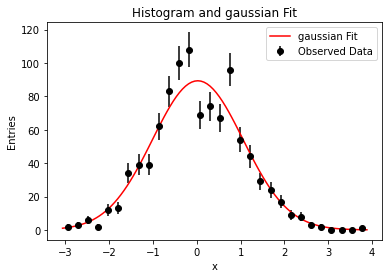

{'prob': 0.008174282114173148,
 'chi-sq': 49.081221627465304,
 'NDF': 28,
 'sigma': (1.0327788200341657, 0.10641571856056231),
 'mean': (0.023115053205441872, 0.16136233055801733)}

In [143]:
gaussian_data = np.random.normal(size=1000)
plot_data_and_fit(gaussian_data, num_bins=30)

You should see a set of black data points with error bars representing the range of values that might be observed if you repeated the experiment.  The red curve is the best-fit gaussian.  It also prints out the best fit value of the `sigma` and `mean`, with errors.  The $\chi^2$ test statistic and corresponding probability are also printed.

Next, try fitting the same data with the `laplace` function.  Compare the probability printout.  Is it more likely that the `gaussian` or `laplace` distribution describes this data?

Chi square:  106.79530296024704
N dof:  28
Chi square Probability:  3.9005465524155625e-11
sigma : 1.2785142936999994 +/- 0.4161644159632504
mean : -0.04245574649712456 +/- 0.2010316685780466


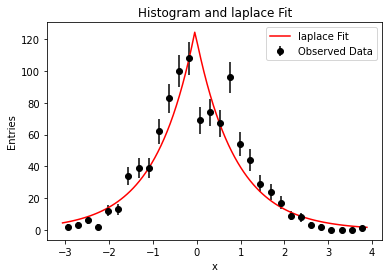

{'prob': 3.9005465524155625e-11,
 'chi-sq': 106.79530296024704,
 'NDF': 28,
 'sigma': (1.2785142936999994, 0.4161644159632504),
 'mean': (-0.04245574649712456, 0.2010316685780466)}

In [144]:
plot_data_and_fit(gaussian_data, num_bins=30, function=laplace)

Many processes in nature are described by guassian distributions (It is the "central limit" and "maximum entropy" probability distribution. If you are curious what this means check out 3Blue1Brown's videos about gaussians on YouTube).

### Exercise 5: Goodness of Fit and $\chi^2$ Probability

If we pick the **right** probability distribution then as we collect more data the value of the $\chi^2$ probability should be more or less unchanged.  If we pick the **wrong** probability distribution to fit the data then as we collect more data it should become more and more clear that we made the wrong choice.  Therefore, the $\chi^2$ probability should decrease as we collect more data, if we made the wrong choice.  Write a `for` loop which on each iteration:

1. Creates a new set of gaussian data with the `size` parameter increasing.  The suggested sizes are already defined for you.
2. Fits the data to both a `gaussian` and a `laplace` distribution.  Save the dictionary returned by each call to `plot_data_and_fit`.  Use the `doPlot=False` argument in `plot_data_and_fit` so that it doesn't try to plot each individual fit.
3. Use the list `append` method to add each successive probability to the `gaus_probs` and `lapl_probs` lists.  You can access the probability in the returned dictionary like `dict["prob"]`.

After your `for` loop you will use `plt.plot` to plot `gaus_probs` and `lapl_probs` on the y-axis as a function of `sizes` on the x-axis.  You will also need to use `plt.xscale('log')` and `plt.yscale('log')` to make the axes have a logarithmic scale.  Try reading the above code that defines `plot_data_and_fit` to set the axis labels and make a legend for your plot.

Sometimes, depending on the generated data, the `plot_data_and_fit` function will complain and produce an error.  You can ignore this.

/Users/kevnels/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:6707: RuntimeWarning: overflow encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/Users/kevnels/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Text(0, 0.5, 'Probability')

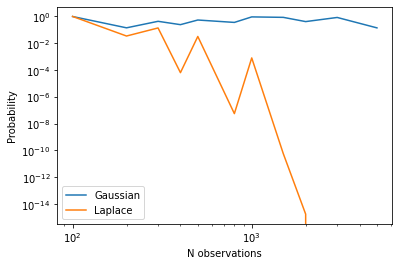

In [117]:
sizes = [100, 200, 300, 400, 500, 800, 1000, 1500, 2000, 3000, 5000]
gaus_probs = []
lapl_probs = []

for s in sizes:
    local_data = np.random.normal(size=s)
    gaus_dict = plot_data_and_fit(local_data, num_bins=30, doPlot=False)
    lapl_dict = plot_data_and_fit(local_data, num_bins=30, doPlot=False, function=laplace)
    gaus_probs.append(gaus_dict["prob"])
    lapl_probs.append(lapl_dict["prob"])
    
plt.plot(sizes, gaus_probs, label='Gaussian')
plt.plot(sizes, lapl_probs, label='Laplace')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N observations')
plt.ylabel('Probability')


About how many data points do we need to start to tell the difference between data distributed like a gaussian or a laplace distribution?

In particle physics we define "discovery" as a probability less than $3\times10^{-7}$.  How many observations would you need to "discover" that this data is not distributed like a laplace distribution?

### Exercise 6: Muon Lifetime

Now that we understand how to fit data and digest the results, we can try to fit the data from our muon lifetime experiment.

The muon decays to an electron and two neutrinos.  Particles that decay should have lifetimes distributed according to an exponential distribution

$$\Large f(t)=\frac{1}{\tau}e^{-t/\tau}$$

Where $t$ is the measured time and $\tau$ is the lifetime of the muon.

First, define a function `exponential` which accepts two arguments: `t` and `tau`.  It should return the function $f(t)$ defined mathematically above.  You can use the `np.exp` function to perform the exponential.

In [123]:
def exponential(t, tau):
    return 1/tau * np.exp(-t / tau)

Run this code to grab the muon lifetime data:

In [124]:
# run this code block without modification
import cloudpickle as cp
from urllib.request import urlopen
lifetime_data = cp.load(urlopen("https://kenelson.web.cern.ch/kenelson/teaching/muon_lifetime.pkl"))

Plot and fit the data.  A suggested additional arugment is `num_bins=40`.

The units on the muon lifetime data are already expressed in microseconds.

Chi square:  1098.8645426591902
N dof:  39
Chi square Probability:  0.0
tau : 2.871392725510664 +/- 0.001426931785661533


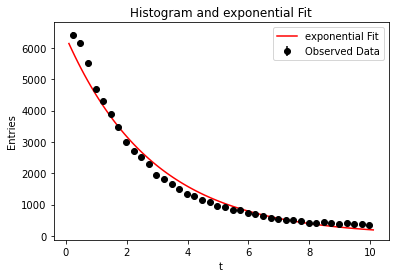

{'prob': 0.0,
 'chi-sq': 1098.8645426591902,
 'NDF': 39,
 'tau': (2.871392725510664, 0.001426931785661533)}

In [170]:
plot_data_and_fit(lifetime_data, function=exponential, num_bins=40)

So, our distribution doesn't look exactly loke an exponential.  We have too many events with a long lifetime.  This could be because we mismatch when one muon enters the tank to when a different muon decays.  To fix this problem, let's restrict ourselves to the data where the measured time was less than 3 microseconds:

Chi square:  140.73662550105678
N dof:  39
Chi square Probability:  2.007283228522283e-13
tau : 2.2792772141795496 +/- 0.2526090695213572


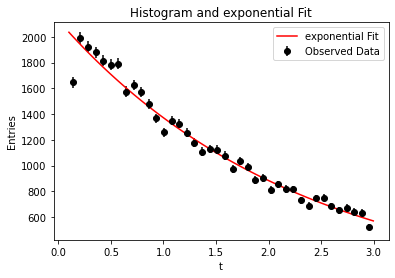

{'prob': 2.007283228522283e-13,
 'chi-sq': 140.73662550105678,
 'NDF': 39,
 'tau': (2.2792772141795496, 0.2526090695213572)}

In [177]:
lifetime_data = lifetime_data[lifetime_data<3]
plot_data_and_fit(lifetime_data, function=exponential, num_bins=40)

That looks better!!!

Study how the fit changes with experiment with respect to the number of data points.  To change the number of points you can "slice" the array as `lifetime_data[:N]` where N is the number of data points.  A suggested progression is a set of logarithmically spaced points from 100 to 60000.  You can also try to make a similar plot to the one you made above for the probability changing as a function of the number of data points. This time, see how the best fit value of `tau` changes as you increase the statistics of the data sample.  You can access the best fit value of tau as `dict["tau"][0]`.

Try plotting the error on tau: `dict["tau"][1]`.  How does the best fit error change as we collect more data?

Text(0, 0.5, 'Best fit lifetime')

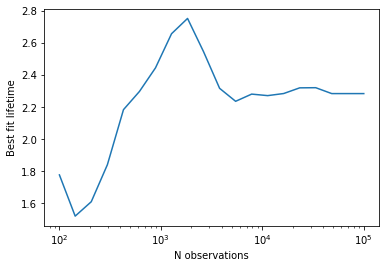

In [178]:
sizes = [int(f) for f in np.logspace(2,5,num=20)]
exp_probs = []

for s in sizes:
    local_data = lifetime_data[:s]
    exp_dict = plot_data_and_fit(local_data, num_bins=25, doPlot=False, function=exponential)
    exp_probs.append(exp_dict["tau"][0])
    
plt.plot(sizes, exp_probs)
plt.xscale('log')
plt.xlabel('N observations')
plt.ylabel('Best fit lifetime')

Text(0, 0.5, 'Best fit error')

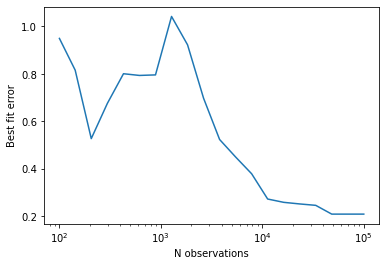

In [179]:
sizes = [int(f) for f in np.logspace(2,5,num=20)]
exp_probs = []

for s in sizes:
    local_data = lifetime_data[:s]
    exp_dict = plot_data_and_fit(local_data, num_bins=25, doPlot=False, function=exponential)
    exp_probs.append(exp_dict["tau"][1])
    
plt.plot(sizes, exp_probs)
plt.xscale('log')
plt.xlabel('N observations')
plt.ylabel('Best fit error')

Next, use `plt.errorbar` to make a plot where the x axis is again the number of observations and on the y axis is the best fit muon lifetime (accessed via `dict["tau"][0]`) and the error bars are the error estimate (accessed via `dict["tau"][0]`).

Text(0, 0.5, 'Best fit muon lifetime')

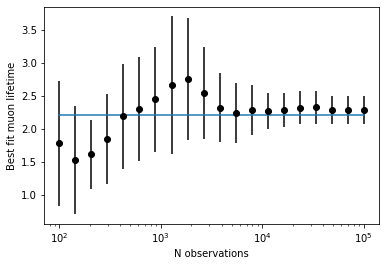

In [180]:
sizes = [int(f) for f in np.logspace(2,5,num=20)]
fit_tau = []
fit_err = []

for s in sizes:
    local_data = lifetime_data[:s]
    exp_dict = plot_data_and_fit(local_data, num_bins=25, doPlot=False, function=exponential)
    fit_tau.append(exp_dict["tau"][0])
    fit_err.append(exp_dict["tau"][1])
    
plt.errorbar(sizes, fit_tau, fit_err, **data_style)
plt.plot(sizes, [2.2]*len(sizes))
plt.xscale('log')
plt.xlabel('N observations')
plt.ylabel('Best fit muon lifetime')

### Challenge Exercise: "Bump Hunt"

In particle physics one way new particles are discovered is via a bump hunt: a smooth "background" spectrum is fit with an exponential or other similar function and a small signal bump appears at a specific mass point.  For example, this is a plot of the mass of two photons coming from a Higgs boson decay in the ATLAS detector:

<div>
<img src="higgs.jpg" width="500"/>
</div>

In this exercise we will investigate toy data and see if we can find a small bump and estimate the probability that this bump is a statistical fluctuation.

Note that we are still using an exponential function but now the x axis is the invariant mass of a pair of photons produced at the LHC.  I have generated mystery data that you will download:

In [126]:
# run this code block without modification
mystery_data_small = cp.load(urlopen("https://kenelson.web.cern.ch/kenelson/teaching/mystery_data_1.pkl"))

First, use `plot_data_and_fit` and see if the observed data is compatible with an exponential fit

Chi square:  14.19474116191188
N dof:  19
Chi square Probability:  0.7722228128133268
tau : 1.6290669533010078 +/- 0.7355945478095088


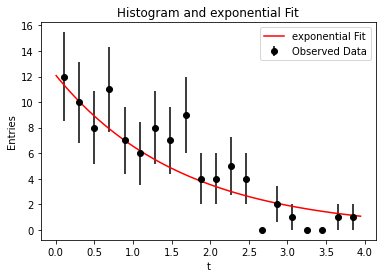

{'prob': 0.7722228128133268,
 'chi-sq': 14.19474116191188,
 'NDF': 19,
 'tau': (1.6290669533010078, 0.7355945478095088)}

In [101]:
plot_data_and_fit(mystery_data_small, num_bins=20, function=exponential)

The data does look like an exponetial with the parameter `tau` near 1.

Now, run the next block of code to load the next data set.  They were generated with the same distribution but the second has more statistics.

Then, plot and fit this data to the `exponential` function.

In [102]:
mystery_data = cp.load(urlopen("https://kenelson.web.cern.ch/kenelson/teaching/mystery_data_2.pkl"))

Chi square:  231.87510246138257
N dof:  19
Chi square Probability:  0.0
tau : 1.1211454633307578 +/- 0.2261325024681462


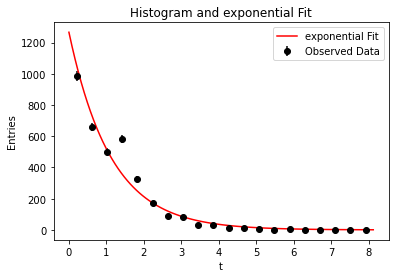

{'prob': 0.0,
 'chi-sq': 231.87510246138257,
 'NDF': 19,
 'tau': (1.1211454633307578, 0.2261325024681462)}

In [103]:
plot_data_and_fit(mystery_data, num_bins=20, function=exponential)

It doesn't look so exponential any more!!! There is a clear "bump" between 1 and 2.

Plot the value of the chi-square probability as a function of the size of the dataset.  You can get a subset of the data inside a `for` loop by executing the line `local_data = mystery_data[:s]` where `s` is some `int` telling you how many data entries to use.  The code to initialize the different sizes of each slice is already written for you.

When you call the function `plot_data_and_fit` inside the `for` loop you should add the argument `doPlot=False` to not make a plot for every fit.  Then, you can store the output dictionary and access the probability:
```
exp_dict = plot_data_and_fit(...)
exp_probs.append(exp_dict["prob"])
```

Text(0, 0.5, 'Best fit chi-sq probability')

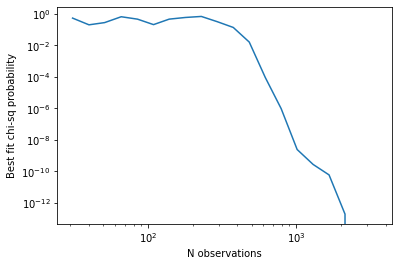

In [104]:
sizes = [int(f) for f in np.logspace(1.5,np.log10(len(mystery_data)),num=20)]
exp_probs = []

for s in sizes:
    local_data = mystery_data[:s]
    exp_dict = plot_data_and_fit(local_data, doPlot=False, function=exponential, guess=50)
    exp_probs.append(exp_dict["prob"])

plt.plot(sizes, exp_probs)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N observations')
plt.ylabel('Best fit chi-sq probability')

So initially the data looks like an exponential, but as we collect more the probability goes to zero, showing us that the expected model is not compatible with the data!  This is how new particles are discovered!

Next, we need to describe the data with some other probability distribution.  It can be a combination of an exponential and gaussian.  The function to define this probability distribution should have five parameters: `x, tau, mu, sigma, gaus_frac` where `gaus_frac` is the fraction of the total probability which is weighted to the gaussian.  Plot the `mystery_data` with an `exponential` fit and an `exponential_plus_gaussian` fit and compare them.

Hint: you can use the existing functions `exponential` and `gaussian` to create your new function `exponential_plus_gaussian`.  The format could look something like:

```
def exponential_plus_gaussian(...):
    return (1-gaus_frac)*exponential(...) + gaus_frac*gaussian(...)
```

When you fit with the `exponential_plus_gaussian` you will need to supply a new argument `guess=[...]` to `plot_data_and_fit`.  This is the best guess initial value of the 4 parameters.  Estimate them by eye from the plot.

Chi square:  186.62271122499948
N dof:  19
Chi square Probability:  0.0
tau : 1.1044726352885188 +/- 0.20379302612520858


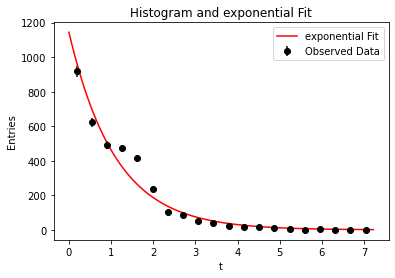

Chi square:  11.466089498566227
N dof:  16
Chi square Probability:  0.7798439204442306
tau : 1.0077976292320625 +/- 0.048797169177890856
mu : 1.5084309328601089 +/- 0.08397680515987992
sigma : 0.3145194998542226 +/- 0.08207103264863497
gaus_frac : 0.14001513806412158 +/- 0.03556731377196629


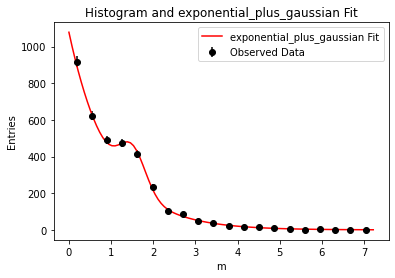

{'prob': 0.7798439204442306,
 'chi-sq': 11.466089498566227,
 'NDF': 16,
 'tau': (1.0077976292320625, 0.048797169177890856),
 'mu': (1.5084309328601089, 0.08397680515987992),
 'sigma': (0.3145194998542226, 0.08207103264863497),
 'gaus_frac': (0.14001513806412158, 0.03556731377196629)}

In [106]:
def exponential_plus_gaussian(m, tau, mu, sigma, gaus_frac):
    return (1-gaus_frac)*exponential(m, tau) + gaus_frac*gaussian(m, sigma, mu)

plot_data_and_fit(mystery_data, num_bins=20, function=exponential)
plot_data_and_fit(mystery_data, num_bins=20, function=exponential_plus_gaussian, guess=[1,1,0.25,0.05])

Chi square:  186.62271122499948
N dof:  19
Chi square Probability:  0.0
tau : 1.1044726352885188 +/- 0.20379302612520858


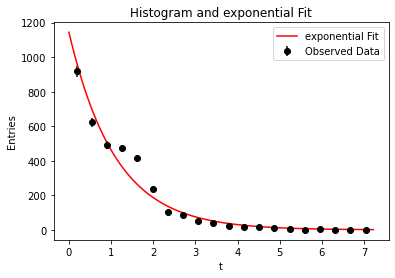

Chi square:  11.466089498566207
N dof:  16
Chi square Probability:  0.7798439204442318
tau : 1.007797628823996 +/- 0.04855231552070416
mu : 1.508430932626224 +/- 0.08316694244285927
sigma : 0.3145195007442169 +/- 0.08160470122716426
gaus_frac : 0.140015138299238 +/- 0.03545888547487077


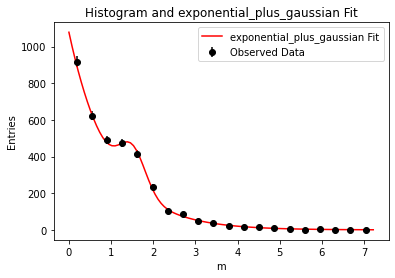

{'prob': 0.7798439204442318,
 'chi-sq': 11.466089498566207,
 'NDF': 16,
 'tau': (1.007797628823996, 0.04855231552070416),
 'mu': (1.508430932626224, 0.08316694244285927),
 'sigma': (0.3145195007442169, 0.08160470122716426),
 'gaus_frac': (0.140015138299238, 0.03545888547487077)}

In [67]:
mystery_data = np.append(np.random.exponential(size=3000), np.random.normal(size=500,loc=1.5,scale=0.3))
np.random.shuffle(mystery_data)
mystery_data = mystery_data[np.where(mystery_data>0)]
plot_data_and_fit(mystery_data, num_bins=20, function=exponential, guess=1)
plot_data_and_fit(mystery_data, num_bins=20, function=exponential_plus_gaussian, guess=[1,1.5,0.3,0.15])

Compare the probabilities of the two fits as a function of the number of observations.  This should look very similar to your code from exercise 5: goodness of fit.

Text(0, 0.5, 'Best fit chi-sq probability')

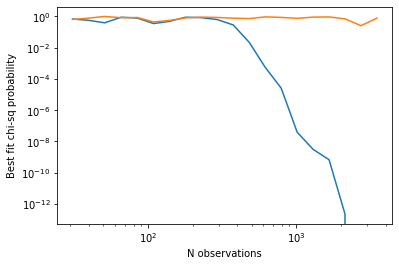

In [107]:
sizes = [int(f) for f in np.logspace(1.5,np.log10(len(mystery_data)),num=20)]
exp_probs = []
plus_probs = []

for s in sizes:
    local_data = mystery_data[:s]
    exp_dict           = plot_data_and_fit(local_data, num_bins=20, doPlot=False, function=exponential, guess=1.2)
    exp_plus_gaus_dict = plot_data_and_fit(local_data, num_bins=20, doPlot=False, function=exponential_plus_gaussian, guess=[1.2,1,0.25,0.15])
    exp_probs.append(exp_dict["prob"])
    plus_probs.append(exp_plus_gaus_dict["prob"])

plt.plot(sizes, exp_probs)
plt.plot(sizes, plus_probs)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N observations')
plt.ylabel('Best fit chi-sq probability')

Another goodness of fit statistic is the value `chi-sq`/`NDF`, the value of the chi-square test statistic over the number of degrees of freedom.  Plot this as a function of the data points (the relevant information is stored in the dictionary returned by `plot_data_and_fit`).  Does it change much?  Why or why not?

In [ ]:
sizes = [int(f) for f in np.logspace(2,5,num=20)]
exp_probs = []

for s in sizes:
    local_data = lifetime_data[:s]
    exp_dict = plot_data_and_fit(local_data, num_bins=25, doPlot=False, function=exponential)
    exp_probs.append(exp_dict["chi-sq"]/exp_dict["NDF"])
    
plt.plot(sizes, exp_probs)
plt.xscale('log')
plt.xlabel('N observations')
plt.ylabel('Best fit chi-sq/NDF')

If you are finished, continue to play with the data and plot other values with respect to N observations.  You can also try reading the code in `plot_data_and_fit` and try to digest what is going on.